In [1]:
from os import listdir, environ, read
from analysis.import_data import split_true_zhh_zzh
from analysis.plot_matplotlib import plot_hist, plot_confusion
from math import pi,sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re

In [2]:
reco = pd.DataFrame(np.load("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/reco/compare_reco_with_mg5.npy", allow_pickle=True))

sigma_zhh_cross_sec = 8.308e-06 # (2.8e-08)pb
sigma_zzh_cross_sec = 1.309e-05 # (4.2e-08)pb
prefac = 1/((2**24)*(pi**18))
pb_to_1oGeV2 = 2.56819e-9

def parse_line_to_float(line:str) -> float:
    a = re.sub('\(\S+\)', '', line)
    a = re.sub('\S+: ', '', a)
    return float(a)

def get_result(event_dir:str, event_idx:int):
    #print(f"{event_dir}/event_{str(event_idx)}/result.txt")
    f = open(f"{event_dir}/event_{str(event_idx)}/result.txt", "r")
    lines = f.readlines()
    line_res_start = 0
    for line in lines:
        if line.startswith("Event"):
            line_res_start += 1
    
    result = [0., 0.]
    if len(lines) > line_res_start and lines[line_res_start].startswith("ZHH"):
        result[0] = parse_line_to_float(lines[line_res_start])
        
    if len(lines) > line_res_start+1 and lines[line_res_start+1].startswith("ZZH"):
        result[1] = parse_line_to_float(lines[line_res_start+1])
    
    return result

def load_results(event_dir):
    events = np.array([int(name.replace("event_", "")) for name in listdir(event_dir)])
    results = np.array([get_result(event_dir, event_idx) for event_idx in events]).T
    results = {
        "event": events,
        "zhh_mem": results[0]*prefac/(sigma_zhh_cross_sec*pb_to_1oGeV2),
        "zzh_mem": results[1]*prefac/(sigma_zzh_cross_sec*pb_to_1oGeV2),
        "zhh_true": reco["zhh_mg5"][events],
        "zzh_true": reco["zzh_mg5"][events],
        "is_zhh": reco["is_zhh"][events],
        "is_zzh": reco["is_zzh"][events]
    }

    results = pd.DataFrame(results)
    results = results[((results["zhh_mem"] > 0) & (results["zzh_mem"] > 0))]

    results["r"] = results["zhh_mem"]/(results["zhh_mem"] + results["zzh_mem"])
    
    return results

def conf_mat(results, threshold:float):
    TP = np.count_nonzero((results["is_zhh"]) & (results["r"] > threshold))
    TN = np.count_nonzero((results["is_zzh"]) & (results["r"] < threshold))

    FN = np.count_nonzero((results["is_zhh"]) & (results["r"] < threshold))
    FP = np.count_nonzero((results["is_zzh"]) & (results["r"] > threshold))
    
    return [
        [TP, FP],
        [FN, TN]
    ]   

def plot_r(data, name, yscale="log"):
    true_zhh, true_zzh = split_true_zhh_zzh(data)

    llr = {
        "zhh_r": true_zhh["r"],
        "zzh_r": true_zzh["r"]
    }

    fig, ax = plt.subplots()
    plot_hist(llr, x = ["zhh_r", "zzh_r"], labels=["ZHH event data", "ZZH event data"], title=r"$D_{bkg}$ " + f"({name})", text_start_y=0.95, text_start_x=0.93, normalize=True, xlim=(-0.02,1.02), xlim_binning=(0,1.1), xlabel=r"$D_{bkg}$", ax=ax, bins=64, yscale=yscale)
    
def best_ts(results, vals=None):
    if vals is None:
        vals = np.linspace(np.min(results["r"]), np.max(results["r"]), 1000)
    
    best = 9999
    best_t = np.max(results["r"])
    for thresh in vals:
        TP = np.count_nonzero((results["is_zhh"]) & (results["r"] > thresh))
        TN = np.count_nonzero((results["is_zzh"]) & (results["r"] < thresh))

        FN = np.count_nonzero((results["is_zhh"]) & (results["r"] < thresh))
        FP = np.count_nonzero((results["is_zzh"]) & (results["r"] > thresh))
        
        cur = sqrt((TP-TN)**2) + FN + FP #+ sqrt((FN-FP)**2)
        if cur < best:
            best = cur
            best_t = thresh
            
    return best_t

In [7]:
np.count_nonzero(reco["passed_preselection"] == 0)

0

In [24]:
print([
    np.count_nonzero(results["zhh_mem"] > results["zzh_mem"]),
    np.count_nonzero(results["zhh_mem"] < results["zzh_mem"])
])

[421, 603]


Physsim + SEP_TF

In [5]:
results = load_results("/nfs/dust/ilc/user/bliewert/mem_integrate/results")

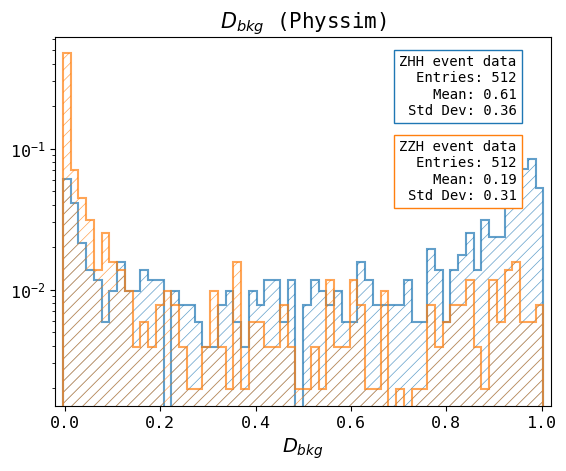

In [6]:
plot_r(results, "Physsim")

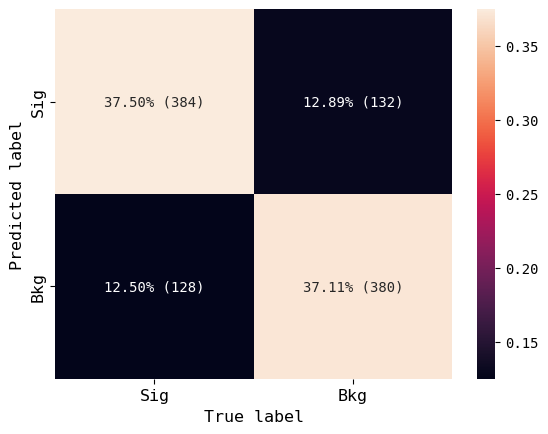

In [36]:
plot_confusion(conf_mat(results, threshold=best_ts(results)), normalize=True)

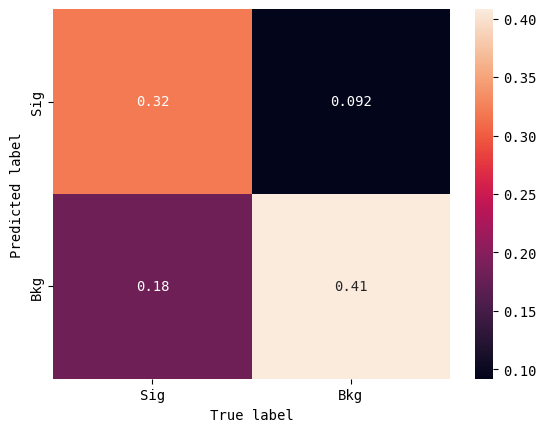

In [10]:
plot_confusion(results, threshold=0.5, normalize=True)

Physsim

In [10]:
results_mg5 = load_results("/nfs/dust/ilc/user/bliewert/mem_integrate_with_septf/results")

0.3001600651559669

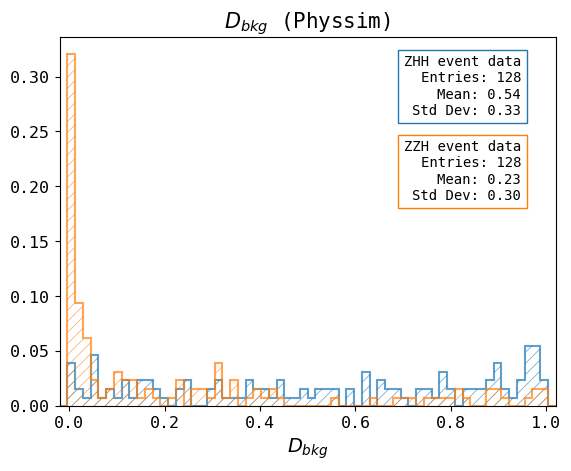

In [11]:
plot_r(results_mg5, "Physsim")
best_ts(results_mg5)

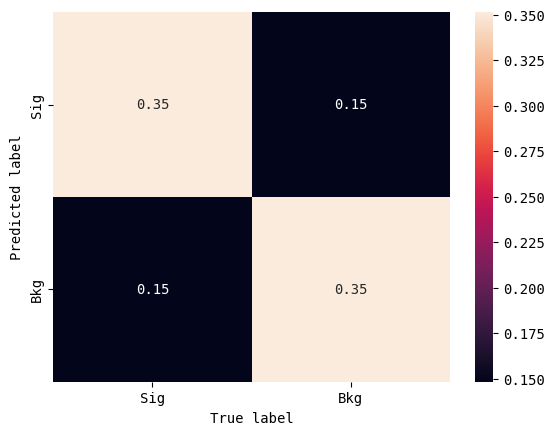

In [13]:
plot_confusion(results_mg5, threshold=0.3001600651559669, normalize=True)

MG5 + SEP-TF

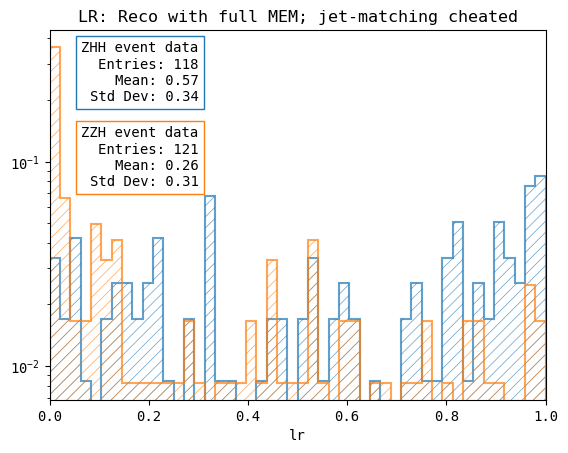

In [24]:
def plot_r(data, name):
    true_zhh, true_zzh = split_true_zhh_zzh(data)

    llr = {
        "zhh_r": true_zhh["r"],
        "zzh_r": true_zzh["r"]
    }

    fig, ax = plt.subplots()
    plot_hist(llr, x = ["zhh_r", "zzh_r"], labels=["ZHH event data", "ZZH event data"], title="LR: {}".format(name), text_start_x= 0.3, normalize=True, xlim=(0.0,1.0), xlim_binning=(0,1.1), xlabel="lr", ax=ax, bins=48, yscale="log")

plot_r(results, "Reco with full MEM; jet-matching cheated")

[Text(0.5, 23.52222222222222, 'Predicted label'),
 Text(50.722222222222214, 0.5, 'True label')]

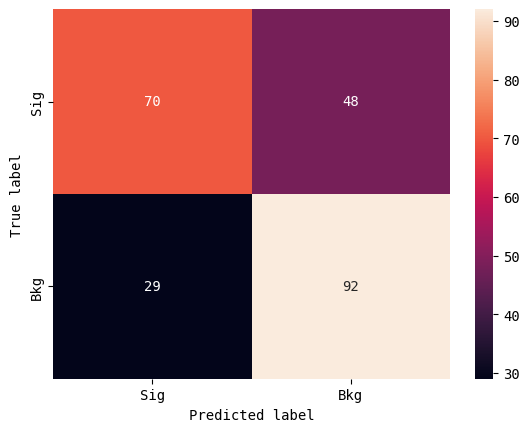

In [19]:
TP = np.count_nonzero((results["is_zhh"]) & (results["r"] > 0.5))
TN = np.count_nonzero((results["is_zzh"]) & (results["r"] < 0.5))

FP = np.count_nonzero((results["is_zhh"]) & (results["r"] < 0.5))
FN = np.count_nonzero((results["is_zzh"]) & (results["r"] > 0.5))

conf_mat = [
    [TP, FP],
    [FN, TN]
]

conf_mat = pd.DataFrame(conf_mat, index=["Sig", "Bkg"], columns=["Sig", "Bkg"])


ax = sns.heatmap(conf_mat, annot=True)
ax.set(xlabel="Predicted label", ylabel="True label")

New

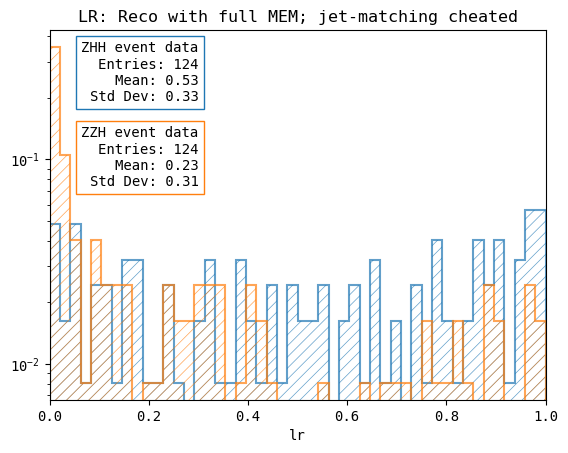

In [5]:
def plot_r(data, name):
    true_zhh, true_zzh = split_true_zhh_zzh(data)

    llr = {
        "zhh_r": true_zhh["r"],
        "zzh_r": true_zzh["r"]
    }

    fig, ax = plt.subplots()
    plot_hist(llr, x = ["zhh_r", "zzh_r"], labels=["ZHH event data", "ZZH event data"], title="LR: {}".format(name), text_start_x= 0.3, normalize=True, xlim=(0.0,1.0), xlim_binning=(0,1.1), xlabel="lr", ax=ax, bins=48, yscale="log")

plot_r(results, "Reco with full MEM; jet-matching cheated")

[Text(0.5, 23.52222222222222, 'Predicted label'),
 Text(50.722222222222214, 0.5, 'True label')]

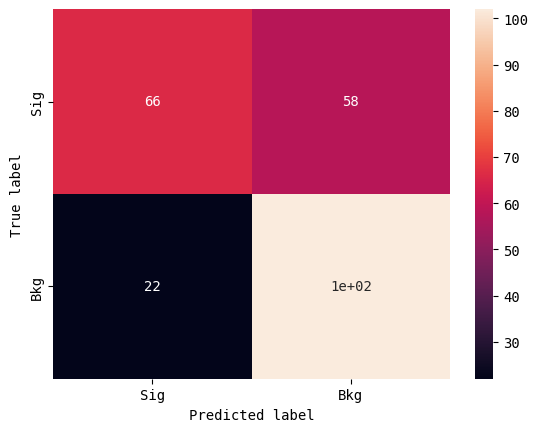

In [6]:
TP = np.count_nonzero((results["is_zhh"]) & (results["r"] > 0.5))
TN = np.count_nonzero((results["is_zzh"]) & (results["r"] < 0.5))

FP = np.count_nonzero((results["is_zhh"]) & (results["r"] < 0.5))
FN = np.count_nonzero((results["is_zzh"]) & (results["r"] > 0.5))

conf_mat = [
    [TP, FP],
    [FN, TN]
]

conf_mat = pd.DataFrame(conf_mat, index=["Sig", "Bkg"], columns=["Sig", "Bkg"])


ax = sns.heatmap(conf_mat, annot=True)
ax.set(xlabel="Predicted label", ylabel="True label")

In [60]:
get_result(event_dir, 24395)

[8.2e-16, 2.84e-19]

In [9]:
read

array([22788, 21238,  5640, 22945, 18969, 23077, 25237,  3737, 26789,
       11424, 24491, 12261, 14787, 16535, 24155, 10630, 23989, 19857,
       24903, 22800, 20323, 22627,   517, 13791,   993, 28360, 16443,
       26294, 18833,  1242, 28366, 23575,  9568, 25009, 16373, 23205,
       28863, 21540, 10861, 12867, 14184,  9643, 24073, 24698, 19180,
       27934, 21492, 26062, 27446, 24971, 11634,  3484, 23903, 27086,
       16339,  6442, 24219, 27246, 26180,  6886, 25352,  6325, 20127,
       21299,     0, 26414, 27810, 26215,  4078, 27140, 23815, 24989,
       15863, 12670, 27231, 19031, 12698, 25634, 18788, 24395, 23427,
        1131, 19341, 26160,  3000, 17034,  5529, 23948, 26108,  7987,
       13053, 24362, 11155, 28903, 17970, 28214,  5437, 17634, 16845,
       27448, 25557, 24210, 23234, 23886, 26010,  9264, 26807, 13576,
        1844, 23592, 12156, 19078, 23756, 16308, 25061, 25366, 25816,
       19288,  2821, 24313, 16742, 27155, 22565, 19084, 26379, 25776,
       27112,  9201,